# Protein Sequence Classification on pfam dataset

## 1. Business Problem

### 1.1 Description

[Proteins](https://en.wikipedia.org/wiki/Protein) are large, complex biomolecules that play many critical roles in biological bodies. Proteins are made up of one or more long chains of [amino acids](https://en.wikipedia.org/wiki/Amino_acid) sequences. These Sequence are the arrangement of amino acids in a protein held together by [peptide bonds](https://en.wikipedia.org/wiki/Peptide_bond). Proteins can be made from [20](https://www.hornetjuice.com/amino-acids-types/) different kinds of amino acids, and the structure and function of each protein are determined by the kinds of amino acids used to make it and how they are arranged. 

Understanding this relationship between amino acid sequence and protein function is a long-standing problem in moleculer biology with far-reaching scientific implications. Can we use deep learning that learns the relationship between unaligned amino acid sequences and their functional annotations across all 17929 families of the Pfam database.

[Pfam](https://en.m.wikipedia.org/wiki/Pfam) is a database of [protein families](https://en.m.wikipedia.org/wiki/Protein_family) that includes their annotations and multiple sequence alignments.

__Problem Statement__
- Classification of protein's amino acid sequence to one of the protein family accession, based on PFam dataset.
- In other words, the task is: given the amino acid sequence of the protein domain, predict which class it belongs to.


### 1.2 Sources/Useful Links

- Source: [Pfam seed random split](https://www.kaggle.com/googleai/pfam-seed-random-split)
- Paper: [Using deep learning to annotate the protein universe](https://www.biorxiv.org/content/10.1101/626507v4.full).

### 1.3 Real world/Business Objectives and Constraints

Objectives
- Predict protein family accession from its amino acids sequence with high accuracy.

Constraints
- No strict latency concerns.

## 2. Machine Learning Problem

### 2.1 Data

#### 2.1.1 Data Overview

- `sequence`: These are usually the input features to the model. Amino acid sequence for this domain. There are 20 very common amino acids (frequency > 1,000,000), and 4 amino acids that are quite uncommon: X, U, B, O, Z.

- `family_accession`: These are usually the labels for the model. Accession number in form PFxxxxx.y (Pfam), where xxxxx is the family accession, and y is the version number. Some values of y are greater than ten, and so 'y' has two digits.

- `sequence_name`: Sequence name, in the form "uniprot_accession_id/start_index-end_index". 

- `aligned_sequence`: Contains a single sequence from the multiple sequence alignment (with the rest of the members of the family in seed, with gaps retained.

- `family_id`: One word name for family. 

#### 2.1.2 Example Data point



```
sequence: HWLQMRDSMNTYNNMVNRCFATCIRSFQEKKVNAEEMDCTKRCVTKFVGYSQRVALRFAE 
family_accession: PF02953.15
sequence_name: C5K6N5_PERM5/28-87
aligned_sequence: ....HWLQMRDSMNTYNNMVNRCFATCI...........RS.F....QEKKVNAEE.....MDCT....KRCVTKFVGYSQRVALRFAE 
family_id: zf-Tim10_DDP
```



#### 2.1.3 Data split

- We have been provided with already done random split(train, val, test) of pfam dataset.
  - Train - 80% (For training the models).
  - Val - 10% (For hyperparameter tuning/model validation).
  - Test - 10% (For acessing the model performance).

### 2.2 Mapping the real world problem to an ML problem

#### 2.2.1 Type of Machine learning Problem

It is a multi class classification problem, for a given sequence of amino acids we need to predict its family accession.

#### 2.2.2 Performance Metric

- Multi class log loss
- Accuracy

## 3. Exploratory Data Analysis

### Importing Libraries

In [1]:
%matplotlib inline

import os
import gc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from prettytable import PrettyTable
from IPython.display import Image

from sklearn.preprocessing import LabelEncoder

from keras.models import Model
from keras.regularizers import l2
from keras.constraints import max_norm
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Dropout, Flatten, Activation
from keras.layers import Conv1D, Add, MaxPooling1D, BatchNormalization
from keras.layers import Embedding, Bidirectional, CuDNNLSTM, GlobalMaxPooling1D

Using TensorFlow backend.


In [0]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

### Loading Data

In [4]:
data_path = 'drive/My Drive/Case_Study/pfam/random_split/'
print('Available data', os.listdir(data_path))

Available data ['dev', 'test', 'train']


In [0]:
# https://www.kaggle.com/drewbryant/starter-pfam-seed-random-split

# data is randomly splitted in three folders [train(80%), test(10%), dev(10%)]
# reading and concatinating data for each folder.

def read_data(partition):
  data = []
  for fn in os.listdir(os.path.join(data_path, partition)):
    with open(os.path.join(data_path, partition, fn)) as f:
      data.append(pd.read_csv(f, index_col=None))
  return pd.concat(data)

In [0]:
# reading all data_partitions

df_train = read_data('train')
df_val = read_data('dev')
df_test = read_data('test')

### Basic Statistics

In [0]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086741 entries, 0 to 13514
Data columns (total 5 columns):
family_id           1086741 non-null object
sequence_name       1086741 non-null object
family_accession    1086741 non-null object
aligned_sequence    1086741 non-null object
sequence            1086741 non-null object
dtypes: object(5)
memory usage: 49.7+ MB


In [0]:
df_train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [0]:
# ex: unaligned sequence
# each character reperesents one of the 24(20 common + 4 uncommon) amino acids in the sequence.

df_train.head(1)['sequence'].values[0]

'PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAILAAAGCAAPFEEFSSADAFSSTHVFGTCRMGHDPMRNVVDGWGRSHRWPNLFVADASLFPSSGGGESPGLTIQALALRT'

In [0]:
# Given data size
print('Train size: ', len(df_train))
print('Val size: ', len(df_val))
print('Test size: ', len(df_test))

Train size:  1086741
Val size:  126171
Test size:  126171


In [0]:
def calc_unique_cls(train, test, val):
  """
  Prints # unique classes in data sets.
  """
  train_unq = np.unique(train['family_accession'].values)
  val_unq = np.unique(val['family_accession'].values)
  test_unq = np.unique(test['family_accession'].values)

  print('Number of unique classes in Train: ', len(train_unq))
  print('Number of unique classes in Val: ', len(val_unq))
  print('Number of unique classes in Test: ', len(test_unq))

In [0]:
# Unique classes in the given dataset : [df_train, df_val and df_test]

calc_unique_cls(df_train, df_test, df_val)

Number of unique classes in Train:  17929
Number of unique classes in Val:  13071
Number of unique classes in Test:  13071


### Sequence Counts

In [0]:
# Length of sequence in train data.
df_train['seq_char_count']= df_train['sequence'].apply(lambda x: len(x))
df_val['seq_char_count']= df_val['sequence'].apply(lambda x: len(x))
df_test['seq_char_count']= df_test['sequence'].apply(lambda x: len(x))

In [0]:
def plot_seq_count(df, data_name):
  sns.distplot(df['seq_char_count'].values)
  plt.title(f'Sequence char count: {data_name}')
  plt.grid(True)

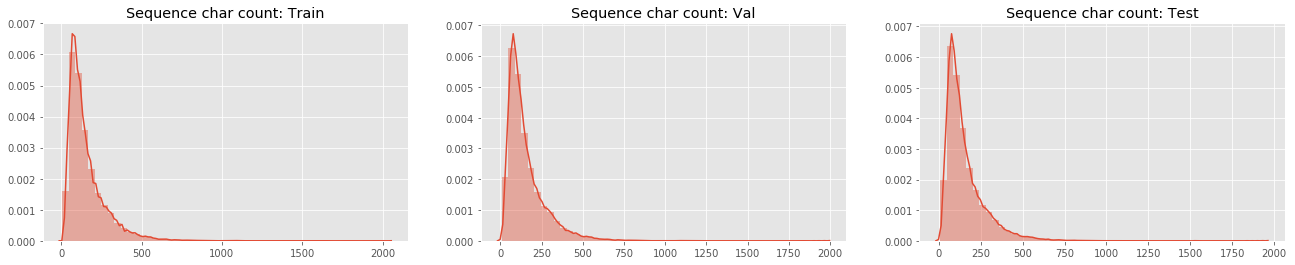

In [58]:
plt.subplot(1, 3, 1)
plot_seq_count(df_train, 'Train')

plt.subplot(1, 3, 2)
plot_seq_count(df_val, 'Val')

plt.subplot(1, 3, 3)
plot_seq_count(df_test, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observation__
- Most of the unaligned amino acid sequences have character counts in the range of 50-250.

### Sequence Code Frequency

Amino acid sequences are represented with their corresponding 1 letter code, for example, code for alanine is (A), arginine is (R) and so on. The complete list of amino acids with there code can be found <a href='http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html'>here</a>.

In [0]:
def get_code_freq(df, data_name):
  
  df = df.apply(lambda x: " ".join(x))
  
  codes = []
  for i in df: # concatination of all codes
    codes.extend(i)

  codes_dict= Counter(codes)
  codes_dict.pop(' ') # removing white space
  
  print(f'Codes: {data_name}')
  print(f'Total unique codes: {len(codes_dict.keys())}')

  df = pd.DataFrame({'Code': list(codes_dict.keys()), 'Freq': list(codes_dict.values())})
  return df.sort_values('Freq', ascending=False).reset_index()[['Code', 'Freq']]

In [60]:
# train code sequence
train_code_freq = get_code_freq(df_train['sequence'], 'Train')
train_code_freq

Codes: Train
Total unique codes: 25


,Code,Freq
0,L,17062816
1,A,14384873
2,V,11913147
3,G,11845579
4,E,10859966
5,S,10597822
6,I,10234455
7,R,9406165
8,D,9371097
9,K,9127832


In [61]:
# val code sequence
val_code_freq = get_code_freq(df_val['sequence'], 'Val')
val_code_freq

Codes: Val
Total unique codes: 22


,Code,Freq
0,L,1967025
1,A,1667703
2,V,1382128
3,G,1376124
4,E,1249356
5,S,1210750
6,I,1185722
7,R,1085950
8,D,1080572
9,K,1047638


In [62]:
# test code sequence
test_code_freq = get_code_freq(df_test['sequence'], 'Test')
test_code_freq

Codes: Test
Total unique codes: 24


,Code,Freq
0,L,1967046
1,A,1668137
2,V,1380962
3,G,1375349
4,E,1251000
5,S,1210559
6,I,1184239
7,R,1085786
8,D,1078379
9,K,1045957


In [0]:
def plot_code_freq(df, data_name):
  
  plt.title(f'Code frequency: {data_name}')
  sns.barplot(x='Code', y='Freq', data=df)

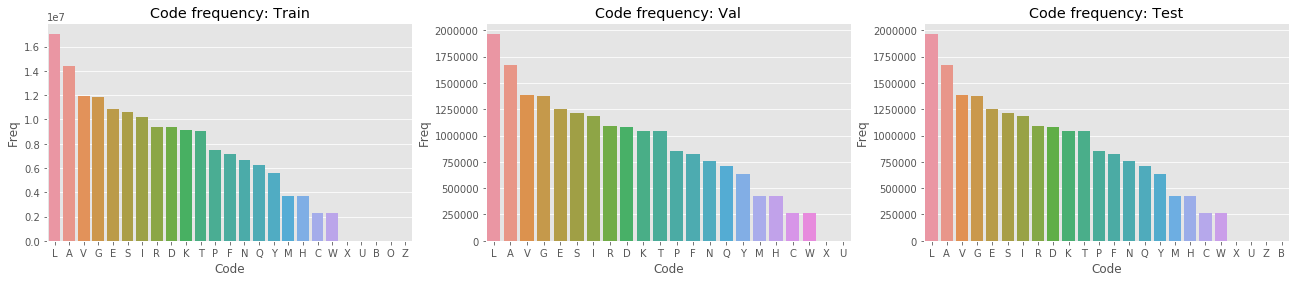

In [64]:
plt.subplot(1, 3, 1)
plot_code_freq(train_code_freq, 'Train')

plt.subplot(1, 3, 2)
plot_code_freq(val_code_freq, 'Val')

plt.subplot(1, 3, 3)
plot_code_freq(test_code_freq, 'Test')

plt.subplots_adjust(right=3.0)
plt.show()

__Observations__
- Most frequent amino acid code is L followed by A, V, G.
- As we can see, that the uncommon amino acids (i.e., X, U, B, O, Z) are present in very less quantity. Therefore we can consider only 20 common natural amino acids for sequence encoding.

### Protein families with most sequences(No. of observations)

In [65]:
df_train.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    3637
LRR_1              1927
Acetyltransf_7     1761
His_kinase         1537
Bac_transf         1528
Lum_binding        1504
DNA_binding_1      1345
Chromate_transp    1265
Lipase_GDSL_2      1252
DnaJ_CXXCXGXG      1210
SRP54_N            1185
WD40               1173
OTCace_N           1171
PEP-utilizers      1147
Glycos_trans_3N    1138
THF_DHG_CYH        1113
Prenyltransf       1104
HTH_1              1064
Maf                1061
DHH                1057
dtype: int64

In [67]:
df_val.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

In [66]:
df_test.groupby('family_id').size().sort_values(ascending=False).head(20)

family_id
Methyltransf_25    454
LRR_1              240
Acetyltransf_7     219
His_kinase         192
Bac_transf         190
Lum_binding        187
DNA_binding_1      168
Chromate_transp    157
Lipase_GDSL_2      156
DnaJ_CXXCXGXG      151
SRP54_N            148
OTCace_N           146
WD40               146
PEP-utilizers      143
Glycos_trans_3N    142
Prenyltransf       138
THF_DHG_CYH        138
HTH_1              133
Maf                132
DHH                131
dtype: int64

__Observation__

- Top 20 classes are same across all the sets [train, test, val].
- Test and Val sets have almost same frequency for the top 20 classes.

### Considering 1000 classes based on no. of observations.

In [16]:
# Considering top 1000 classes based on most observations because of limited computational power.

classes = df_train['family_accession'].value_counts()[:1000].index.tolist()
len(classes)

1000

In [17]:
# Filtering data based on considered 1000 classes.
train_sm = df_train.loc[df_train['family_accession'].isin(classes)].reset_index()
val_sm = df_val.loc[df_val['family_accession'].isin(classes)].reset_index()
test_sm = df_test.loc[df_test['family_accession'].isin(classes)].reset_index()

print('Data size after considering 1000 classes for each data split:')
print('Train size :', len(train_sm))
print('Val size :', len(val_sm))
print('Test size :', len(test_sm))

Data size after considering 1000 classes for each data split:
Train size : 439493
Val size : 54378
Test size : 54378


In [19]:
# No. of unique classes after reducing the data size.

calc_unique_cls(train_sm, test_sm, val_sm)

Number of unique classes in Train:  1000
Number of unique classes in Val:  1000
Number of unique classes in Test:  1000


## 4. Deep Learning Models

### Text Preprocessing

In [20]:
# https://dmnfarrell.github.io/bioinformatics/mhclearning
# http://www.cryst.bbk.ac.uk/education/AminoAcid/the_twenty.html
# 1 letter code for 20 natural amino acids

codes = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
         'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
  char_dict = {}
  for index, val in enumerate(codes):
    char_dict[val] = index+1

  return char_dict

char_dict = create_dict(codes)

print(char_dict)
print("Dict Length:", len(char_dict))

{'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}
Dict Length: 20


In [0]:
def integer_encoding(data):
  """
  - Encodes code sequence to integer values.
  - 20 common amino acids are taken into consideration
    and rest 4 are categorized as 0.
  """
  
  encode_list = []
  for row in data['sequence'].values:
    row_encode = []
    for code in row:
      row_encode.append(char_dict.get(code, 0))
    encode_list.append(np.array(row_encode))
  
  return encode_list

In [0]:
train_encode = integer_encoding(train_sm) 
val_encode = integer_encoding(val_sm) 
test_encode = integer_encoding(test_sm) 

In [23]:
# padding sequences

max_length = 100
train_pad = pad_sequences(train_encode, maxlen=max_length, padding='post', truncating='post')
val_pad = pad_sequences(val_encode, maxlen=max_length, padding='post', truncating='post')
test_pad = pad_sequences(test_encode, maxlen=max_length, padding='post', truncating='post')

train_pad.shape, val_pad.shape, test_pad.shape

((439493, 100), (54378, 100), (54378, 100))

In [24]:
# One hot encoding of sequences

train_ohe = to_categorical(train_pad)
val_ohe = to_categorical(val_pad)
test_ohe = to_categorical(test_pad)

train_ohe.shape, test_ohe.shape, test_ohe.shape 

((439493, 100, 21), (54378, 100, 21), (54378, 100, 21))

In [0]:
# del train_pad, val_pad, test_pad
# del train_encode, val_encode, test_encode

# gc.collect()

In [26]:
# label/integer encoding output variable: (y)
le = LabelEncoder()

y_train_le = le.fit_transform(train_sm['family_accession'])
y_val_le = le.transform(val_sm['family_accession'])
y_test_le = le.transform(test_sm['family_accession'])

y_train_le.shape, y_val_le.shape, y_test_le.shape

((439493,), (54378,), (54378,))

In [27]:
print('Total classes: ', len(le.classes_))
# le.classes_

Total classes:  1000


In [28]:
# One hot encoding of outputs
y_train = to_categorical(y_train_le)
y_val = to_categorical(y_val_le)
y_test = to_categorical(y_test_le)

y_train.shape, y_val.shape, y_test.shape

((439493, 1000), (54378, 1000), (54378, 1000))

In [0]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

In [0]:
# Utility function: Display model score(Loss & Accuracy) across all sets.

def display_model_score(model, train, val, test, batch_size):

  train_score = model.evaluate(train[0], train[1], batch_size=batch_size, verbose=1)
  print('Train loss: ', train_score[0])
  print('Train accuracy: ', train_score[1])
  print('-'*70)

  val_score = model.evaluate(val[0], val[1], batch_size=batch_size, verbose=1)
  print('Val loss: ', val_score[0])
  print('Val accuracy: ', val_score[1])
  print('-'*70)
  
  test_score = model.evaluate(test[0], test[1], batch_size=batch_size, verbose=1)
  print('Test loss: ', test_score[0])
  print('Test accuracy: ', test_score[1])

### Model 1: Bidirectional LSTM

In [36]:
x_input = Input(shape=(100,))
emb = Embedding(21, 128, input_length=max_length)(x_input)
bi_rnn = Bidirectional(CuDNNLSTM(64, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01)))(emb)
x = Dropout(0.3)(bi_rnn)

# softmax classifier
x_output = Dense(1000, activation='softmax')(x)

model1 = Model(inputs=x_input, outputs=x_output)
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model1.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 100, 128)          2688      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               99328     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1000)              129000    
Total params: 231,016
Trainable params: 231,016
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [38]:
history1 = model1.fit(
    train_pad, y_train,
    epochs=50, batch_size=256,
    validation_data=(val_pad, y_val),
    callbacks=[es]
    )

Train on 439493 samples, validate on 54378 samples
Epoch 1/50
439493/439493 [==============================] - 78s 178us/step - loss: 5.5381 - acc: 0.1120 - val_loss: 3.5944 - val_acc: 0.3442
Epoch 2/50
439493/439493 [==============================] - 77s 176us/step - loss: 2.8564 - acc: 0.4733 - val_loss: 2.0159 - val_acc: 0.6706
Epoch 3/50
439493/439493 [==============================] - 77s 175us/step - loss: 1.9031 - acc: 0.6607 - val_loss: 1.3857 - val_acc: 0.7869
Epoch 4/50
439493/439493 [==============================] - 77s 176us/step - loss: 1.4633 - acc: 0.7459 - val_loss: 1.0834 - val_acc: 0.8410
Epoch 5/50
439493/439493 [==============================] - 77s 176us/step - loss: 1.2147 - acc: 0.7920 - val_loss: 0.8749 - val_acc: 0.8773
Epoch 6/50
439493/439493 [==============================] - 77s 175us/step - loss: 1.0633 - acc: 0.8202 - val_loss: 0.8003 - val_acc: 0.8885
Epoch 7/50
439493/439493 [==============================] - 77s 175us/step - loss: 0.9566 - acc: 0.8389

In [0]:
# saving model weights.
model1.save_weights('drive/My Drive/Case_Study/pfam/model1.h5')

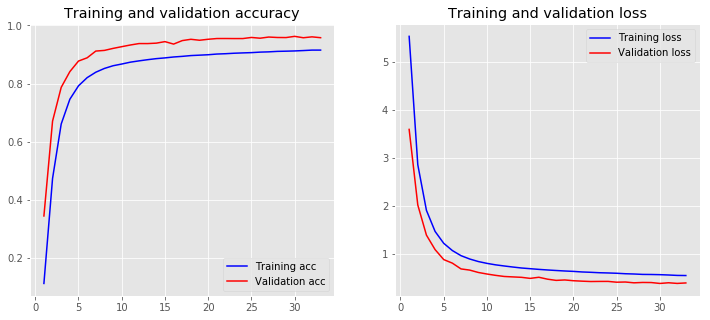

In [39]:
plot_history(history1)

In [44]:
display_model_score(model1,
    [train_pad, y_train],
    [val_pad, y_val],
    [test_pad, y_test],
    256)

439493/439493 [==============================] - 28s 65us/step
Train loss:  0.36330516427409587
Train accuracy:  0.9645910173696531
----------------------------------------------------------------------
54378/54378 [==============================] - 3s 63us/step
Val loss:  0.3869630661736021
Val accuracy:  0.9577034830108782
----------------------------------------------------------------------
54378/54378 [==============================] - 3s 64us/step
Test loss:  0.3869193921893196
Test accuracy:  0.9587149214887501


### Model 2: ProtCNN (https://www.biorxiv.org/content/10.1101/626507v4.full)

<br/>
<center><img src='https://www.biorxiv.org/content/biorxiv/early/2019/07/15/626507/F6.large.jpg' height='470' width='700'></center>

<br/>

- One hot encoded unaligned sequence of amino acids is passed as the input to the network with zero padding.

- This network uses residual blocks inspired from [ResNet](https://arxiv.org/abs/1512.03385) architecture which also includes dilated convolutions offering larger receptive field without increasing number of model parameters.

In [0]:
def residual_block(data, filters, d_rate):
  """
  _data: input
  _filters: convolution filters
  _d_rate: dilation rate
  """

  shortcut = data

  bn1 = BatchNormalization()(data)
  act1 = Activation('relu')(bn1)
  conv1 = Conv1D(filters, 1, dilation_rate=d_rate, padding='same', kernel_regularizer=l2(0.001))(act1)

  #bottleneck convolution
  bn2 = BatchNormalization()(conv1)
  act2 = Activation('relu')(bn2)
  conv2 = Conv1D(filters, 3, padding='same', kernel_regularizer=l2(0.001))(act2)

  #skip connection
  x = Add()([conv2, shortcut])

  return x

In [50]:
# model

x_input = Input(shape=(100, 21))

#initial conv
conv = Conv1D(128, 1, padding='same')(x_input) 

# per-residue representation
res1 = residual_block(conv, 128, 2)
res2 = residual_block(res1, 128, 3)

x = MaxPooling1D(3)(res2)
x = Dropout(0.5)(x)

# softmax classifier
x = Flatten()(x)
x_output = Dense(1000, activation='softmax', kernel_regularizer=l2(0.0001))(x)

model2 = Model(inputs=x_input, outputs=x_output)
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100, 21)      0                                            
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 100, 128)     2816        input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_5 (BatchNor (None, 100, 128)     512         conv1d_6[0][0]                   
__________________________________________________________________________________________________
activation_5 (Activation)       (None, 100, 128)     0           batch_normalization_5[0][0]      
____________________________________________________________________________________________

In [0]:
# Early Stopping
es = EarlyStopping(monitor='val_loss', patience=3, verbose=1)

In [51]:
history2 = model2.fit(
    train_ohe, y_train,
    epochs=10, batch_size=256,
    validation_data=(val_ohe, y_val),
    callbacks=[es]
    )

Train on 439493 samples, validate on 54378 samples
Epoch 1/10
439493/439493 [==============================] - 120s 272us/step - loss: 0.9157 - acc: 0.9294 - val_loss: 0.4761 - val_acc: 0.9838
Epoch 2/10
439493/439493 [==============================] - 114s 260us/step - loss: 0.4438 - acc: 0.9788 - val_loss: 0.4545 - val_acc: 0.9831
Epoch 3/10
439493/439493 [==============================] - 114s 260us/step - loss: 0.4331 - acc: 0.9814 - val_loss: 0.4443 - val_acc: 0.9848
Epoch 4/10
439493/439493 [==============================] - 114s 260us/step - loss: 0.4198 - acc: 0.9825 - val_loss: 0.4279 - val_acc: 0.9863
Epoch 5/10
439493/439493 [==============================] - 114s 260us/step - loss: 0.4098 - acc: 0.9830 - val_loss: 0.4314 - val_acc: 0.9859
Epoch 6/10
439493/439493 [==============================] - 114s 260us/step - loss: 0.4033 - acc: 0.9834 - val_loss: 0.4181 - val_acc: 0.9867
Epoch 7/10
439493/439493 [==============================] - 114s 260us/step - loss: 0.3943 - acc:

In [0]:
# saving model weights.
model2.save_weights('drive/My Drive/Case_Study/pfam/model2.h5')

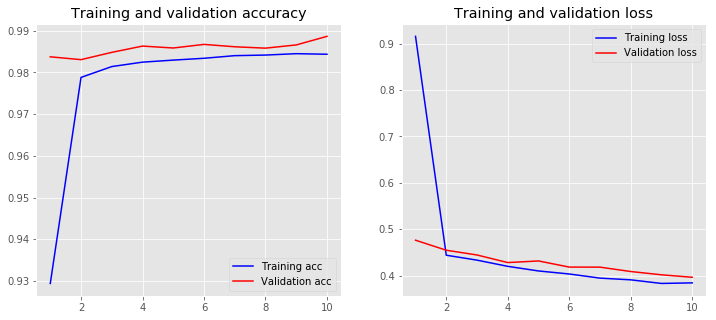

In [52]:
plot_history(history2)

In [53]:
display_model_score(
    model2,
    [train_ohe, y_train],
    [val_ohe, y_val],
    [test_ohe, y_test],
    256)

439493/439493 [==============================] - 38s 85us/step
Train loss:  0.3558084576734698
Train accuracy:  0.9969123512774948
----------------------------------------------------------------------
54378/54378 [==============================] - 5s 85us/step
Val loss:  0.39615299251274316
Val accuracy:  0.9886718893955224
----------------------------------------------------------------------
54378/54378 [==============================] - 5s 85us/step
Test loss:  0.3949931418234982
Test accuracy:  0.9882489242257847


## 5. Conclusion

In [55]:
x = PrettyTable()
x.field_names = ['Sr.no', 'Model', 'Train Acc', 'Val Acc','Test Acc']

x.add_row(['1.', 'Bidirectional LSTM', '0.964', '0.957', '0.958'])
x.add_row(['2.', 'ProtCNN', '0.996', '0.988', '0.988'])

print(x)

+-------+--------------------+-----------+---------+----------+
| Sr.no |       Model        | Train Acc | Val Acc | Test Acc |
+-------+--------------------+-----------+---------+----------+
|   1.  | Bidirectional LSTM |   0.964   |  0.957  |  0.958   |
|   2.  |      ProtCNN       |   0.996   |  0.988  |  0.988   |
+-------+--------------------+-----------+---------+----------+


### Reference:

- https://www.biorxiv.org/content/10.1101/626507v4.full